In [1]:
import matplotlib.pyplot as plt

from skimage.color import rgb2hsv

from skimage import io
import numpy as np
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage
from PIL import Image
#import statistics
import pickle as pkl
from scipy import stats

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams.update({'font.size': 14})

In [2]:
from PIL import Image
imtemp = Image.open('Scanned Document.jpg')
print(imtemp.info['dpi'])
imtemp.close()

(100, 100)


In [3]:
from PIL import Image
im = Image.open('LAMP_color_detection_by_scanner.png')
print(im.info['dpi'])

(300, 300)


In [4]:
pic.

SyntaxError: invalid syntax (<ipython-input-4-5801f031c90b>, line 1)

In [5]:
pic = io.imread('Scanned Document.jpg', )
#Flip left right because image is take from the bottom of the plate
pic = np.fliplr(pic)
#Translate RGB to HSV
hsv_pic = rgb2hsv(pic, )

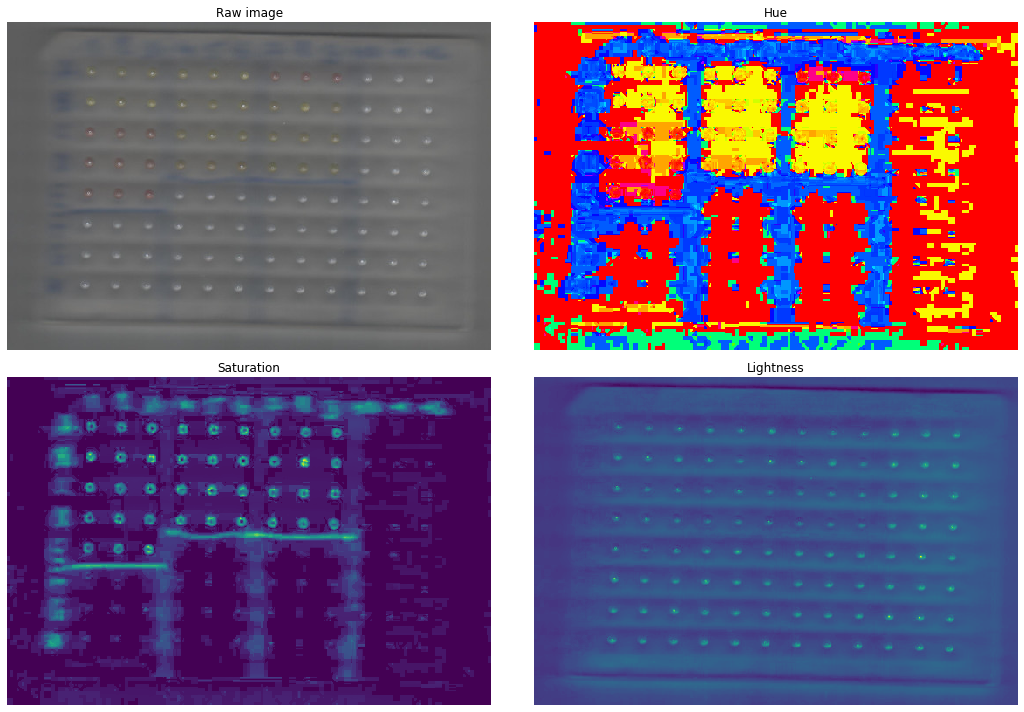

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2,  figsize=(15, 10), )
ax0, ax1, ax2, ax3 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]
ax0.imshow(pic)
ax0.set_title('Raw image')
ax0.set_axis_off()
ax1.imshow(hsv_pic[:, :, 0], cmap='hsv')
ax1.set_title('Hue')
ax1.set_axis_off()
ax2.imshow(hsv_pic[:, :, 1])
ax2.set_title('Saturation')
ax2.set_axis_off()
ax3.imshow(hsv_pic[:, :, 2])
ax3.set_title('Lightness')
ax3.set_axis_off()
plt.tight_layout()
#plt.savefig('raw_hsv.png', dpi=300)

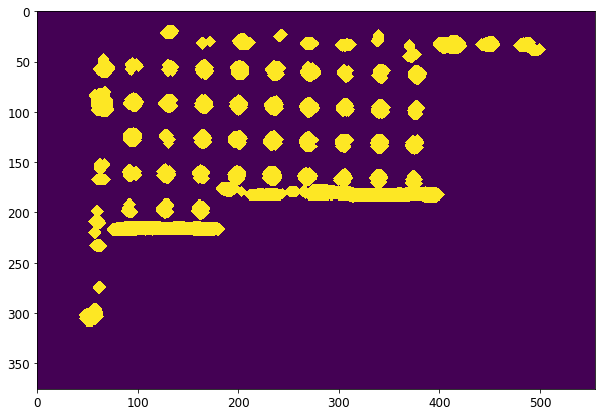

In [7]:
#Find the threshold for the saturation
plt.figure(figsize=(10,10))

saturation = hsv_pic[:, :, 1].copy()
threshold_s= 0.14
mask_sat = saturation>threshold_s
mask_sat = binary_dilation(mask_sat, iterations=5)
plt.imshow(mask_sat)

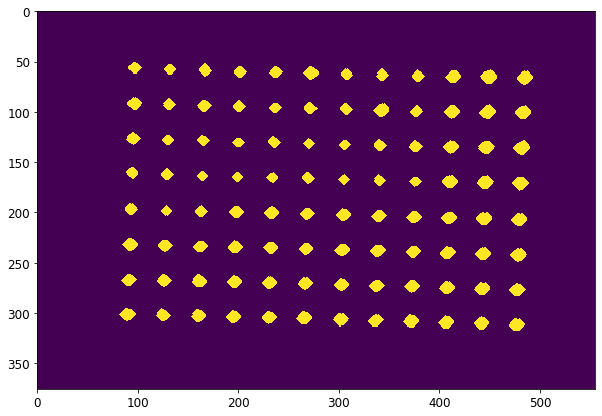

In [8]:
#Find the threshold for the lightness
plt.figure(figsize=(10,10))

val = hsv_pic[:, :, 2].copy()
threshold_v= 0.50
mask_val = val>threshold_v
mask_val = binary_dilation(mask_val, iterations=4)

plt.imshow(mask_val)

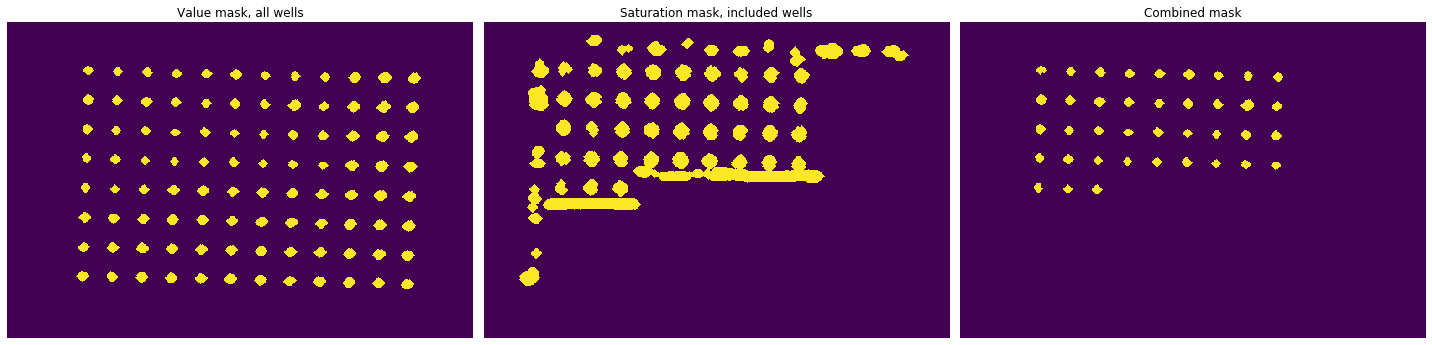

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,10))

#Combine masks
mask = np.logical_and(mask_val, mask_sat)

ax0.imshow(mask_val)
ax0.set_title('Value mask, all wells')
ax0.set_axis_off()
ax1.imshow(mask_sat)
ax1.set_title('Saturation mask, included wells')
ax1.set_axis_off()
ax2.imshow(mask)
ax2.set_title('Combined mask')
ax2.set_axis_off()

plt.tight_layout()
#plt.savefig('masks.png', dpi=300, transparent=True)

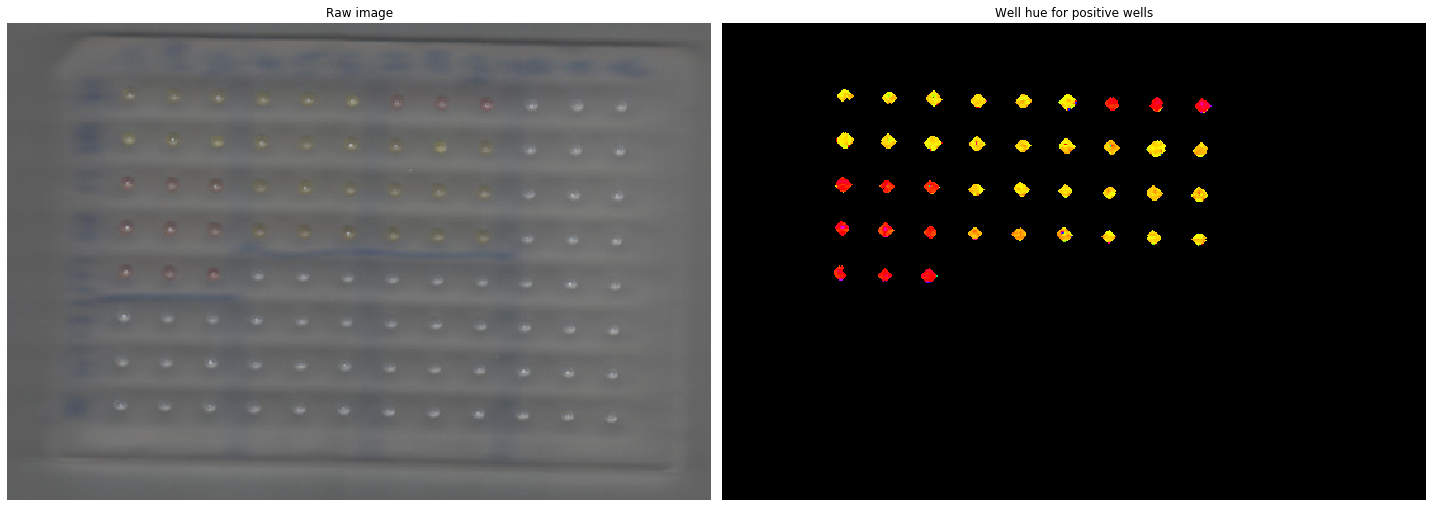

In [10]:
#Use values to make a mask for the wells
val = hsv_pic[:, :, 2].copy()
threshold_v= 0.50
mask_val = val>threshold_v
mask_val = binary_dilation(mask_val, iterations=4)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(pic)
ax0.set_axis_off()
ax0.set_title('Raw image')


#Use the saturation to maks wells with samples
saturation = hsv_pic[:, :, 1].copy()
threshold_s= 0.14
mask_sat = saturation>threshold_s
mask_sat = binary_dilation(mask_sat, iterations=4)

#Combine masks
mask = np.logical_and(mask_val, mask_sat)

#masked image
result  = hsv_pic[:, :, 0].copy()
result_masked = np.ma.masked_where(mask==False, result)
cmap = plt.cm.hsv
cmap.set_bad(color='black')

ax1.imshow(result_masked, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Well hue for positive wells')

plt.tight_layout()
#plt.savefig('LAMP_color_detection_by_scanner.png', dpi=300)

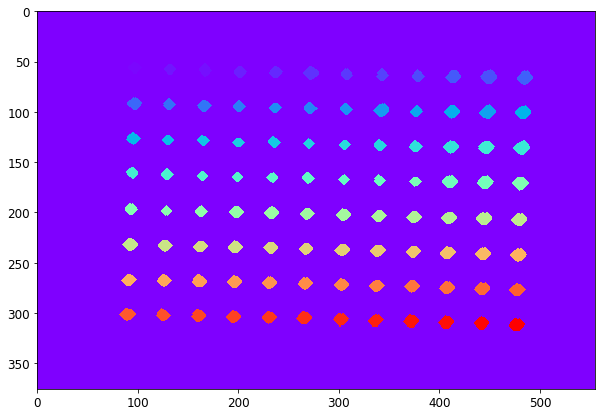

In [11]:
# Segment the image of all wells
labels, nobjects = ndimage.label(mask_val.astype(int))
# labels will not be sorted in a microtiter plate structure because of small variations in label positions. 

# Find the centers of each well
centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))
plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='rainbow')

In [12]:
import scipy

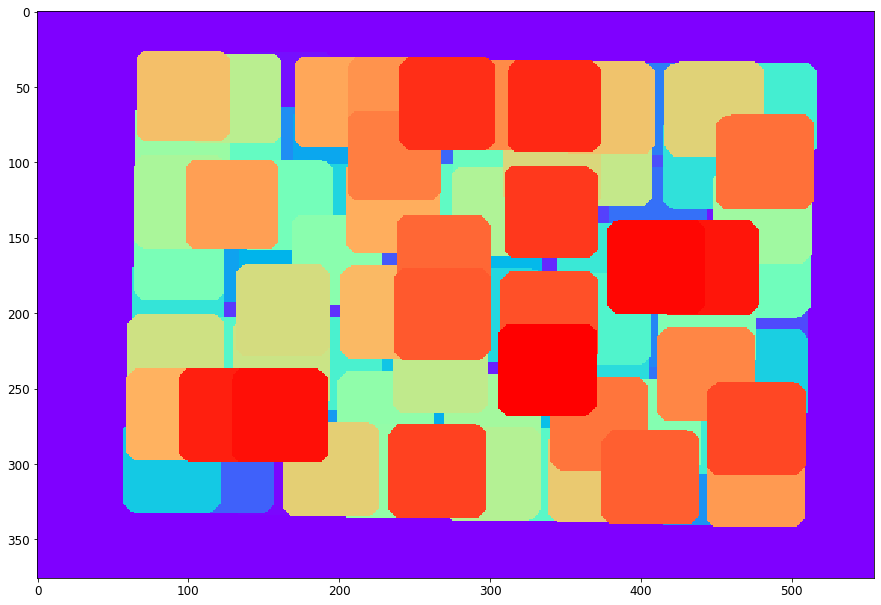

In [13]:
plt.figure(figsize=(15,15))

mask=labels
unique = np.unique(mask)
unique = np.delete(unique, np.array([0]))
shuffeled = unique.copy()
np.random.shuffle(shuffeled)
mix = dict(zip(unique, shuffeled))
mix[0] = 0
shuffeled_mask = np.array([mix[i] for  i in mask.ravel()])
shuffeled_mask = shuffeled_mask.reshape(mask.shape)

shuffeled_mask = np.ma.masked_where(shuffeled_mask==0, shuffeled_mask)

plt.imshow(scipy.ndimage.grey_dilation(shuffeled_mask, size=(50,50), ), cmap='rainbow')

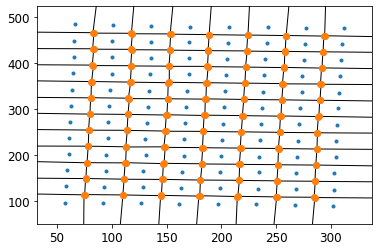

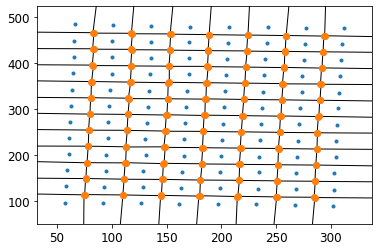

In [14]:
scipy.spatial.voronoi_plot_2d(scipy.spatial.Voronoi(centers))

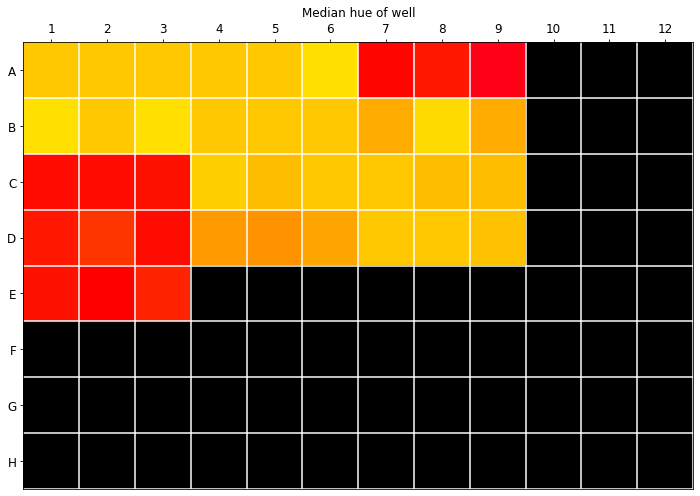

In [15]:
# Find the mediand hue of each positive well
median_result = np.zeros(nobjects)
filled = np.ma.filled(result_masked, np.nan)

#Sort the centers of the wells so that they are in order of the microtiter plate
sort = np.lexsort((centers[:,1], centers[:,0]))
label_order = np.unique(labels)[1:]

for n, s in enumerate(sort):
    values = filled[labels == label_order[s]]
    values = values[np.isfinite(values)]
    if values.size > 0:
        median_result[n] = np.median(values)
    else:
        median_result[n] = np.nan
        
plt.figure(figsize=(12,10))
plt.imshow(median_result.reshape((8,12)), cmap='hsv')
plt.yticks(np.arange(0, 8, 1),labels=[i for i in 'ABCDEFGH'])
plt.ylim(7.5,-0.5)
plt.xticks(np.arange(0, 12, 1),labels=np.arange(1, 13, 1))
plt.gca().xaxis.tick_top()

for r in range(8):
    plt.hlines(r+0.5, -0.5,11.5, color='white')
for c in range(12):
    plt.vlines(c+0.5, -0.5, 7.5, color='white')

plt.title('Median hue of well');
#plt.savefig('Median_well_hue.png', dpi=300)

[]

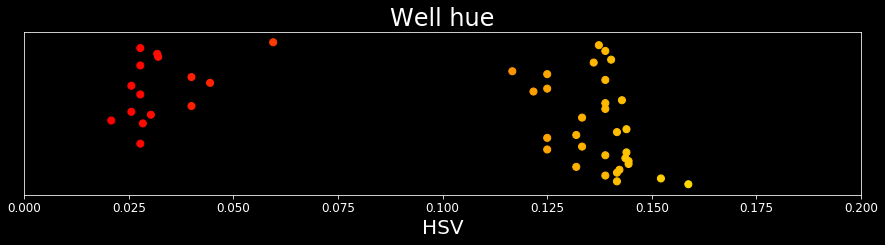

In [255]:

plt.style.use('dark_background')
plt.figure(figsize=(15,3))
c_result = median_result[np.isfinite(median_result)]
plt.scatter(c_result, np.arange(0, 1, 1/c_result.shape[0]), c=c_result,cmap=plt.cm.hsv, s=50) #np.random.random(c_result.shape)

plt.xlim(0,0.2)
plt.title('Well hue', fontsize=24)
plt.xlabel('HSV', fontsize=20)
plt.gca().yaxis.set_ticklabels([])
plt.gca().yaxis.set_visible(False)
plt.gca().yaxis.set_ticks([])

# Function

0.06 96


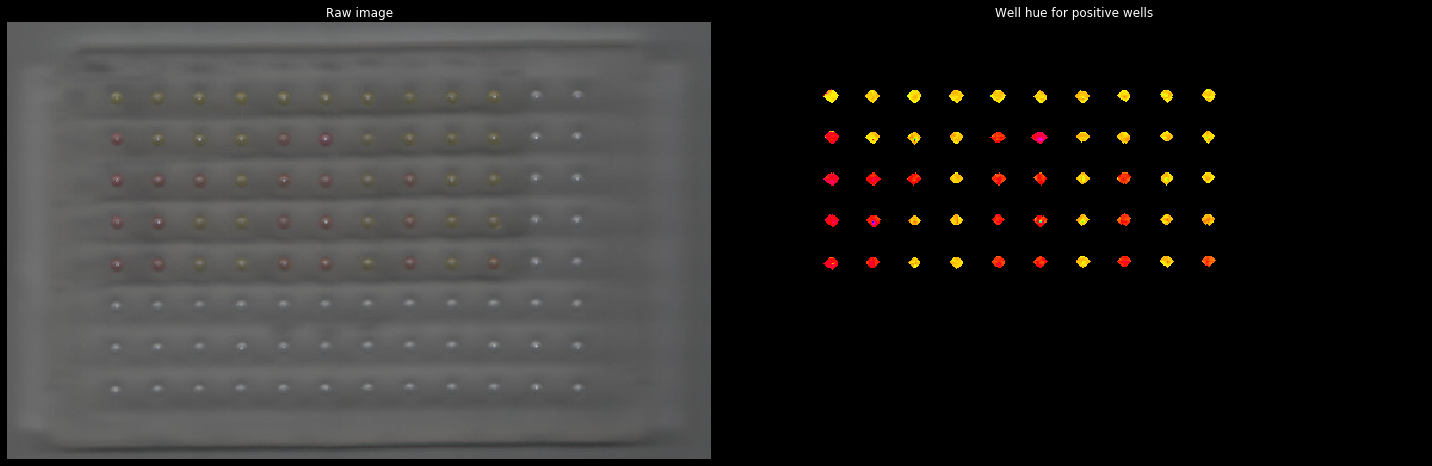

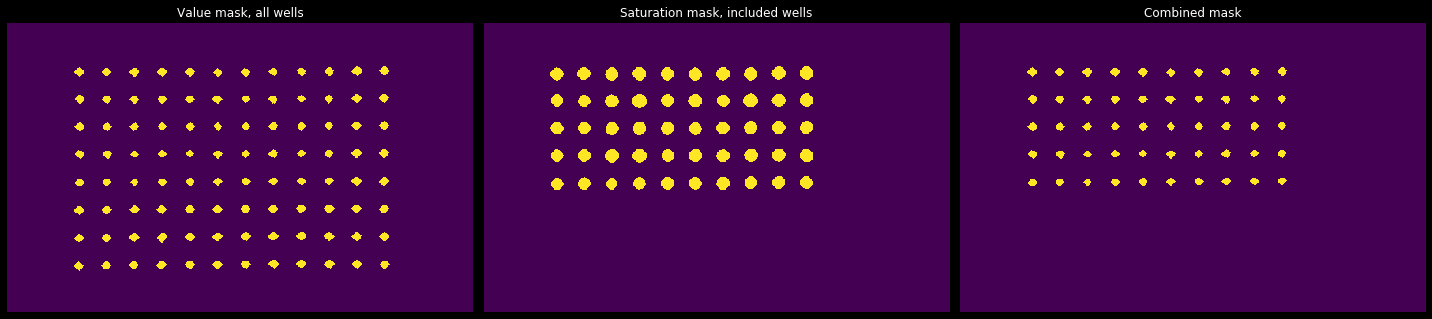

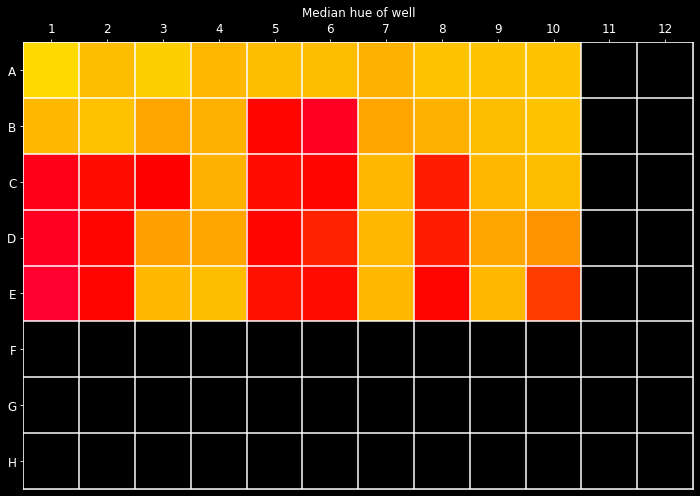

In [205]:
fname ='Plate_2.jpg'
threshold_v = 0.5
threshold_s = 0.14

plate_size = 96
well_size = None


pic = io.imread(fname)
#Flip left right because image is take from the bottom of the plate
pic = np.fliplr(pic)
#Translate RGB to HSV
hsv_pic = rgb2hsv(pic)

############################################

# Try to determine size of the well in the image if not defined. 
if well_size == None:
    try:
        #get the dpi
        imtemp = Image.open(fname)
        dpi = np.mean((imtemp.info['dpi'][0], imtemp.info['dpi'][1]))
        imtemp.close()

        if plate_size == 96:
            well_diameter = 3 #mm
        if plate_size == 384:
            well_diameter = 2 #mm  Is this correct ??????

        #Calculate expected diameter of well in pixels
        well_size = (well_diameter / 25.4) * dpi #pixels

    except Exception as e:
        raise Exception(f'Could not find the dpi of the image, please provide the "well_size" in pixels to the function. Error: {e}')


#Use values to make a mask for the wells
# Filter the image
val = hsv_pic[:, :, 2].copy()
val = val - scipy.ndimage.filters.gaussian_filter(val, int(well_size / 2))

# Iterate through thresholds untill the expected number of wells is found.
for t in np.arange(0, 1, 0.01):
    threshold_v = t
    mask_val = val>threshold_v
    # Expand the wells with a third of the well size
    mask_val = binary_dilation(mask_val, iterations = int(well_size/3))
    # Segment the image of all wells
    labels, nobjects = ndimage.label(mask_val.astype(int))
    if nobjects == plate_size:
        print(t, nobjects)
        break        
        
############################################

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
ax0.imshow(pic)
ax0.set_axis_off()
ax0.set_title('Raw image')


#Use the saturation to maks wells with samples
saturation = hsv_pic[:, :, 1].copy()
saturation = scipy.ndimage.filters.gaussian_filter(saturation, int(well_size / 3))

# Iterate through thresholds to find wells with samples
sat_thresholds = []
sat_threshold_result = []
for t in np.arange(0.005, 1, 0.005):
    mask_sat = saturation > t
    mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
    labels, nobjects = ndimage.label(mask_sat.astype(int))
    sat_thresholds.append(t)
    sat_threshold_result.append(nobjects)
    if nobjects == 0:
        break
sat_thresholds = np.array(sat_thresholds)
sat_threshold_result = np.array(sat_threshold_result) 

# Find the threshold for the positive wells
sat_result_mask = np.bitwise_and(sat_threshold_result > 0, sat_threshold_result <= plate_size)
mode = statistics.mode(sat_threshold_result[sat_result_mask])
sat_threshold = sat_thresholds[sat_threshold_result == mode][int(sat_thresholds[sat_threshold_result == mode].shape[0]/2)]

# Make the final mask with the found threshold
mask_sat = saturation > sat_threshold
mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
labels, nobjects = ndimage.label(mask_sat.astype(int))

############################################

#Combine masks
mask = np.logical_and(mask_val, mask_sat)


#masked image
result  = hsv_pic[:, :, 0].copy()
result_masked = np.ma.masked_where(mask==False, result)
cmap = plt.cm.hsv
cmap.set_bad(color='black')

ax1.imshow(result_masked, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Well hue for positive wells')

plt.tight_layout()
#plt.savefig('LAMP_color_detection_by_scanner.png', dpi=300)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20,10))

#Combine masks
mask = np.logical_and(mask_val, mask_sat)

ax0.imshow(mask_val)
ax0.set_title('Value mask, all wells')
ax0.set_axis_off()
ax1.imshow(mask_sat)
ax1.set_title('Saturation mask, included wells')
ax1.set_axis_off()
ax2.imshow(mask)
ax2.set_title('Combined mask')
ax2.set_axis_off()

plt.tight_layout()



# Segment the image of all wells
labels, nobjects = ndimage.label(mask_val.astype(int))
label_order = np.unique(labels)[1:]

# Find the centers of each well
centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))


# Sort the wells, this works for these images but needs imporvement. 
# It works well with the distance in pixels between the wells.
# Using the centroids it should be possible to find this distance.
# Current solution with 33: 
# Sum the X and Y value of the centers but multipy the X value so that 
# centers get a sortable value
cent_argsort = np.argsort([33*i[0] + i[1] for i in centers])


# Find the median hue of each positive well
median_result = np.zeros(nobjects)
filled = np.ma.filled(result_masked, np.nan)
# Loop through the sorted centroids and calculate median hue.
for n, c in enumerate(cent_argsort):
    # Mask the well of interest
    values = filled[labels == label_order[c]]
    values = values[np.isfinite(values)]
    # Check if well has a sample
    if values.size > 0:
        # Median hue, to exclude outliers
        median_result[n] = np.median(values)
    else:
        median_result[n] = np.nan

# Plot results      
plt.figure(figsize=(12,10))
plt.imshow(median_result.reshape((8,12)), cmap='hsv')
plt.yticks(np.arange(0, 8, 1),labels=[i for i in 'ABCDEFGH'])
plt.ylim(7.5,-0.5)
plt.xticks(np.arange(0, 12, 1),labels=np.arange(1, 13, 1))
plt.gca().xaxis.tick_top()
for r in range(8):
    plt.hlines(r+0.5, -0.5,11.5, color='white')
for c in range(12):
    plt.vlines(c+0.5, -0.5, 7.5, color='white')

plt.title('Median hue of well');
#plt.savefig('Median_well_hue.png', dpi=300)

0.5034722222222222


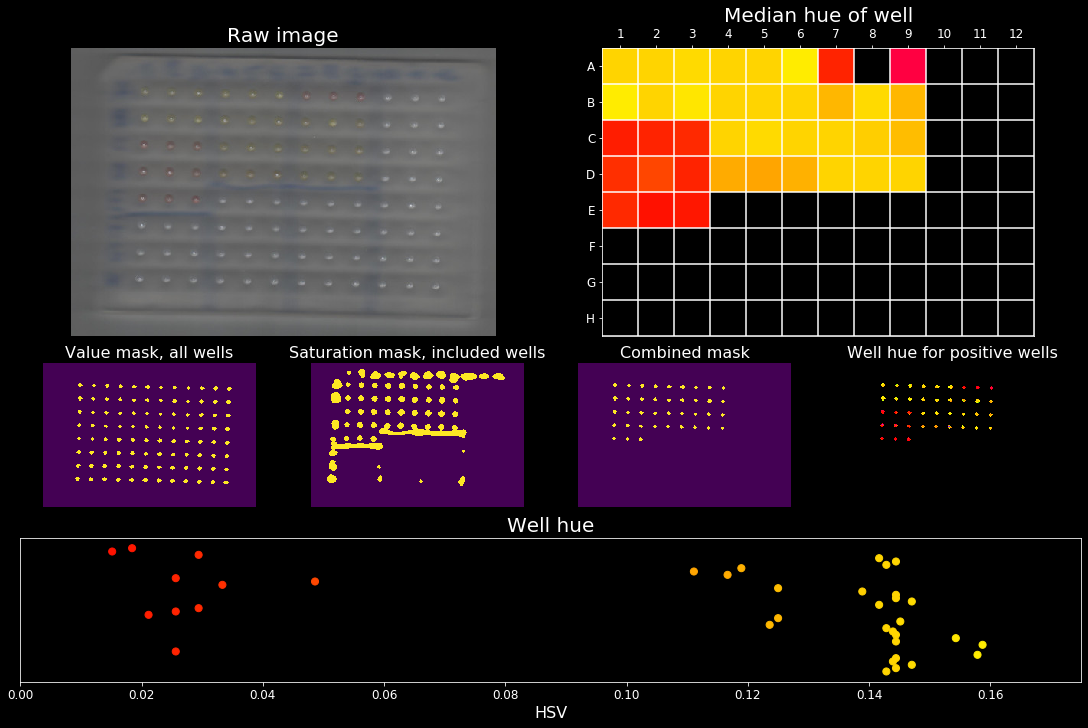

In [77]:
def evaluate(fname, plateID=None, plate_size=96, well_size=None, plot=True, save=True, save_plot=False, hue_min=0, hue_max=1):
    """
    Evaluate the hues of each sample of a colormetric assay in a microtiter well plate.
    Input:
    `fname`: Image file name.
    `plateID`: Identification number of sample plate.
    `plate_size`(int): number of wells. 96 or 384.
    `well_size(int): Optional size of well in pixels. will be estimated automatically
        if possible.
    `plot`(bool): Plot the results
    `save`(bool): Save the results.
    `save_plot`(bool): Save the plot.
    `hue_min`(flt): Minimum of expected hue of the colormetric test. 
        The HSV color scheme is used, where hue is an angle between 0 and 1.
        Reds can be found on eiter end of the scale as it is a circle. 
        "hum_min" can therefore be set to any minimal angle and can cross the origin.
        Example: to capture all reds set "hue_min" to 0.9 and "hue_max" to 0.1
        This will allow all colors between 0.9 --> 0 --> 0.1
    `hue_max`(flt): Maximum expected hue. See explanation above.
    
    Returns:
        Dictionary with the results, with well IDs as keys and hue as value.
        If selected it saves the plots as image and the results as pickled dictionary.
    
    """
    
    def check_angle(angle, min_angle, max_angle):
        """
        Function to check if hue is within range of expected results.
        Hue is an angle between 0 and 1. 
        Reds can be found at both the start and end of the circle

        """
        # Normal situation
        if min_angle < max_angle:
            if min_angle < angle < max_angle:
                return True
            else:
                return False

        # Range is on either side of the start.
        if min_angle > max_angle:
            if (angle > min_angle and angle < 1) or (angle > 0 and angle < max_angle):
                return True
            else:
                return False
    
    pic = io.imread(fname)
    #Flip left right because image is take from the bottom of the plate
    pic = np.fliplr(pic)
    #Translate RGB to HSV
    hsv_pic = rgb2hsv(pic)

    # Plot raw image
    if plot == True:
        plt.style.use('dark_background')
        fig = plt.figure(constrained_layout=True, figsize=(15,10))
        gs = fig.add_gridspec(4,4)
        ax0 = fig.add_subplot(gs[:2, :2])
        ax0.imshow(pic)
        ax0.set_axis_off()
        ax0.set_title('Raw image', fontsize=20)

    # Try to determine size of the well in the image if not defined. 
    if well_size == None:
        try:
            #get the dpi
            imtemp = Image.open(fname)
            dpi = np.mean((imtemp.info['dpi'][0], imtemp.info['dpi'][1]))
            imtemp.close()

            if plate_size == 96:
                well_diameter = 3 #mm
            if plate_size == 384:
                well_diameter = 2 #mm  Is this correct ??????

            #Calculate expected diameter of well in pixels
            well_size = (well_diameter / 25.4) * dpi #pixels

        except Exception as e:
            raise Exception(f'Could not find the dpi of the image, please provide the "well_size" in pixels to the function. Error: {e}')


    #Use values to make a mask for the wells
    # Filter the image
    val = hsv_pic[:, :, 2].copy()
    val = val - ndimage.filters.gaussian_filter(val, int(well_size / 2))

    # Iterate through thresholds untill the expected number of wells is found.
    for t in np.arange(0, 1, 0.01):
        threshold_v = t
        mask_val = val>threshold_v
        # Expand the wells with a third of the well size
        mask_val = binary_dilation(mask_val, iterations = int(well_size/3))
        # Segment the image of all wells
        labels, nobjects = ndimage.label(mask_val.astype(int))
        if nobjects == plate_size:
            break        

    #Use the saturation to maks wells with samples
    saturation = hsv_pic[:, :, 1].copy()
    saturation = ndimage.filters.gaussian_filter(saturation, int(well_size / 3))

    # Iterate through thresholds to find wells with samples
    sat_thresholds = []
    sat_threshold_result = []
    for t in np.arange(0.005, 1, 0.001):
        mask_sat = saturation > t
        mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
        labels, nobjects = ndimage.label(mask_sat.astype(int))
        sat_thresholds.append(t)
        sat_threshold_result.append(nobjects)
        if nobjects == 0:
            break
    sat_thresholds = np.array(sat_thresholds)
    sat_threshold_result = np.array(sat_threshold_result) 

    # Find the threshold for the positive wells
    sat_result_mask = np.bitwise_and(sat_threshold_result > 10, sat_threshold_result <= plate_size)
    mode = stats.mode(sat_threshold_result[sat_result_mask])[0]
    sat_threshold = sat_thresholds[sat_threshold_result == mode][int(sat_thresholds[sat_threshold_result == mode].shape[0]/2)]

    # Make the final mask with the found threshold
    mask_sat = saturation > sat_threshold
    mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
    labels, nobjects = ndimage.label(mask_sat.astype(int))

    #Combine masks
    mask = np.logical_and(mask_val, mask_sat)


    #masked image
    result  = hsv_pic[:, :, 0].copy()
    result_masked = np.ma.masked_where(mask==False, result)

    #Combine masks
    mask = np.logical_and(mask_val, mask_sat)

    if plot == True:
        #Plot maskes
        ax2 = fig.add_subplot(gs[2, 0])
        ax2.imshow(mask_val)
        ax2.set_title('Value mask, all wells', fontsize=16)
        ax2.set_axis_off()
        ax3 = fig.add_subplot(gs[2, 1])
        ax3.imshow(mask_sat)
        ax3.set_title('Saturation mask, included wells', fontsize=16)
        ax3.set_axis_off()
        ax4 = fig.add_subplot(gs[2, 2])
        ax4.imshow(mask)
        ax4.set_title('Combined mask', fontsize=16)
        ax4.set_axis_off()
        ax5 = fig.add_subplot(gs[2, 3])
        cmap_ax5 = plt.cm.hsv
        cmap_ax5.set_bad(color='black')
        ax5.imshow(result_masked, cmap=cmap_ax5)
        ax5.set_axis_off()
        ax5.set_title('Well hue for positive wells', fontsize=16)


    # Segment the image of all wells
    labels, nobjects = ndimage.label(mask_val.astype(int))
    label_order = np.unique(labels)[1:]

    # Find the centers of each well
    centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))


    # Sort the wells, this works for these images but needs imporvement. 
    # It works well with the distance in pixels between the wells.
    # Using the centroids it should be possible to find this distance.
    # Current solution with 33: 
    # Sum the X and Y value of the centers but multipy the X value so that 
    # centers get a sortable value
    cent_argsort = np.argsort([33*i[0] + i[1] for i in centers])


    # Find the median hue of each positive well
    median_result = np.zeros(nobjects)
    filled = np.ma.filled(result_masked, np.nan)
    # Loop through the sorted centroids and calculate median hue.
    for n, c in enumerate(cent_argsort):
        # Mask the well of interest
        values = filled[labels == label_order[c]]
        values = values[np.isfinite(values)]
        # Check if well has a sample
        if values.size:
            # Median hue, to exclude outliers
            mr = np.median(values)
            # Check if median is withing expected hues
            if check_angle(mr, hue_min, hue_max):
                median_result[n] = mr
            else:
                print(mr)
                median_result[n] = np.nan
        else:
            median_result[n] = np.nan

    if plate_size == 96:
        w, h = 8, 12
        well_labels = 'ABCDEFGH'
    if plate_size == 384:
        w, h = 16, 24
        well_labels = 'ABCDEFGHIJKLMNOP'

    result = {}
    count = 0
    for r in well_labels:
        for c in range(h):
            result[f'{r}{c}'] = median_result[count]
            count += 1

    # Save the results
    if save == True:
        if plateID == None:
            save_name = f"{fname.split('.')[0]}.pkl"
        else:
            save_name = f"{plateID}.pkl"
        pkl.dump(result, open(save_name, 'wb'))
        print(f'Results saved as pickeled python dictionary, file name: "{save_name}"')


    if plot == True:
        # Plot results in plate format
        ax1 = fig.add_subplot(gs[0:2, 2:4])
        ax1.imshow(median_result.reshape((8,12)), cmap=plt.cm.hsv, vmin=0, vmax=1) #plt.cm.hsv
        plt.yticks(np.arange(0, 8, 1), labels=[i for i in well_labels])
        ax1.set_ylim(7.5,-0.5)
        plt.xticks(np.arange(0, 12, 1),labels=np.arange(1, h+1, 1))
        ax1.xaxis.tick_top()
        for r in range(w):
            ax1.hlines(r+0.5, -0.5, h-0.5, color='white')
        for c in range(h):
            ax1.vlines(c+0.5, -0.5, w-0.5, color='white')
        ax1.set_title('Median hue of well', fontsize=20)

        # Plot results in HSV format
        ax6 = fig.add_subplot(gs[3, :])
        hue_result = median_result[np.isfinite(median_result)]
        ax6.scatter(hue_result, np.arange(0, 1, 1/hue_result.shape[0]), c=hue_result, cmap='hsv', s=50, vmin=0, vmax=1)
        ax6.set_xlim(0,0.175)
        ax6.set_title('Well hue', fontsize=20)
        ax6.set_xlabel('HSV', fontsize=16)
        ax6.yaxis.set_ticklabels([])
        ax6.yaxis.set_visible(False)
        ax6.yaxis.set_ticks([])
    
    return result

r = evaluate('Scanned Document.jpg', save=False, hue_min=0.8, hue_max=0.2)

In [72]:
def check_angle(angle, min_angle, max_angle):
    """
    Function to check if hue is within range of expected results.
    Hue is an angle between 0 and 1. 
    Reds can be found at both the start and end of the circle
    
    """
    # Normal situation
    if min_angle < max_angle:
        if min_angle < angle < max_angle:
            return True
        else:
            return False
    
    # Range is on either side of the start.
    if min_angle > max_angle:
        if (angle > min_angle and angle < 1) or (angle > 0 and angle < max_angle):
            return True
        else:
            return False
        
check_angle(0.96, 0.9, 0.2)

True

In [71]:
angle, min_angle, max_angle = 0.96, 0.9, 0.2

(angle > min_angle and angle < 1) #or (angle > 0 and angle < max_angle)

True

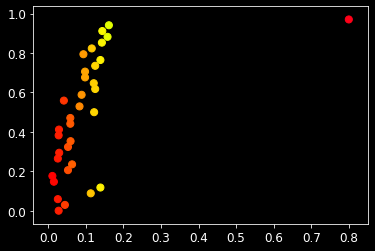

In [31]:
qq = mr[np.isfinite(mr)]
qq = np.append(qq, 0.8)
plt.scatter(qq, np.arange(0, 1, 1/qq.shape[0]), c=qq, cmap='hsv', s=50)

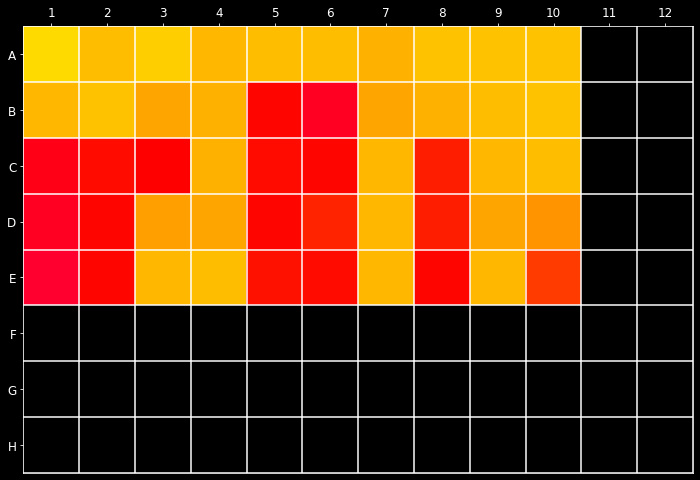

In [197]:
# Segment the image of all wells
labels, nobjects = ndimage.label(mask_val.astype(int))
label_order = np.unique(labels)[1:]

# Find the centers of each well
centers = np.array(ndimage.center_of_mass(mask_val.astype(int), labels=labels, index=np.unique(labels)[1:]))


# Sort the wells, this works for these images but needs imporvement. 
# It works well with the distance in pixels between the wells.
# Using the centroids it should be possible to find this distance.
# Current solution with 33: 
# Sum the X and Y value of the centers but multipy the X value so that 
# centers get a sortable value
cent_argsort = np.argsort([33*i[0] + i[1] for i in centers])


#plt.figure(figsize=(10,10))
#plt.imshow(labels, cmap='rainbow')
#for n, i in enumerate(centers):
#    plt.text(i[1], i[0], n)
    
#for i,n in zip(centers, ccomb_sort):
#    plt.text(i[1], i[0], n)
    
#for n, i in enumerate(cent_argsort):
#    plt.text(centers[i][1], centers[i][0], n)

# Find the median hue of each positive well
median_result = np.zeros(nobjects)
filled = np.ma.filled(result_masked, np.nan)
# Loop through the sorted centroids and calculate median hue.
for n, c in enumerate(cent_argsort):
    # Mask the well of interest
    values = filled[labels == label_order[c]]
    values = values[np.isfinite(values)]
    # Check if well has a sample
    if values.size > 0:
        # Median hue, to exclude outliers
        median_result[n] = np.median(values)
    else:
        median_result[n] = np.nan

        
plt.figure(figsize=(12,10))
plt.imshow(median_result.reshape((8,12)), cmap='hsv')
plt.yticks(np.arange(0, 8, 1),labels=[i for i in 'ABCDEFGH'])
plt.ylim(7.5,-0.5)
plt.xticks(np.arange(0, 12, 1),labels=np.arange(1, 13, 1))
plt.gca().xaxis.tick_top()
for r in range(8):
    plt.hlines(r+0.5, -0.5,11.5, color='white')
for c in range(12):
    plt.vlines(c+0.5, -0.5, 7.5, color='white')

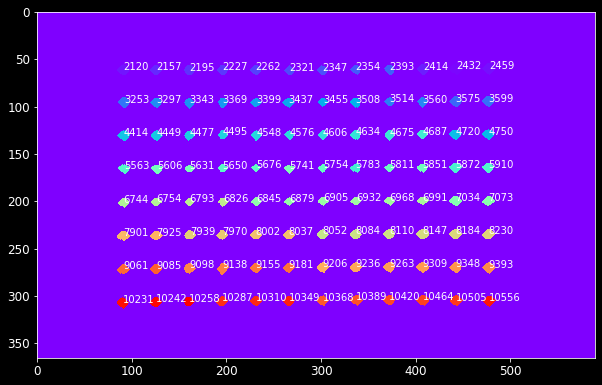

In [187]:
ccomb = [33*i[0] + i[1] for i in centers]

plt.figure(figsize=(10,10))
plt.imshow(labels, cmap='rainbow')
    
for i,n in zip(centers, ccomb):
    plt.text(i[1], i[0], int(n))


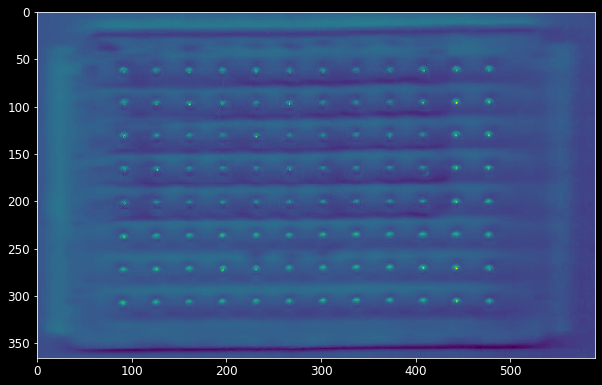

In [31]:
plt.figure(figsize=(10,10))

val = hsv_pic[:, :, 2].copy()

plt.imshow(val)

In [47]:
hsv_pic.

647820

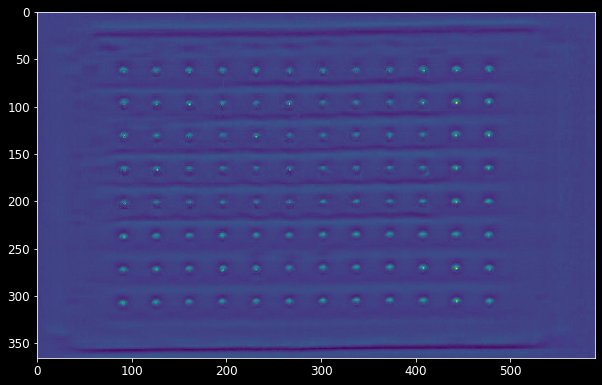

In [57]:
plt.figure(figsize=(10,10))

val = hsv_pic[:, :, 2].copy()
val = val - scipy.ndimage.filters.gaussian_filter(val, 5)
plt.imshow(val)

In [72]:
np.mean((imtemp.info['dpi'][1], imtemp.info['dpi'][0] ))

100.0

0.06 96


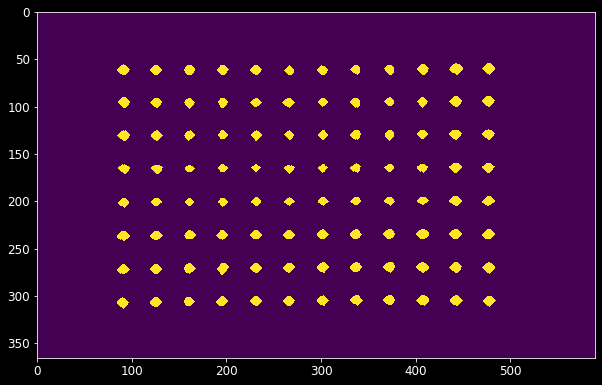

In [20]:
#Find the threshold for the lightness
plt.figure(figsize=(10,10))
plate_size = 96
well_size = None

# Try to determine size of the well in the image. 
if well_size == None:
    try:
        #get the dpi
        imtemp = Image.open(fname)
        dpi = np.mean((imtemp.info['dpi'][0], imtemp.info['dpi'][1]))
        imtemp.close()

        if plate_size == 96:
            well_diameter = 3 #mm
        if plate_size == 384:
            well_diameter = 2 #mm  Is this correct ??????

        #Calculate expected diameter of well in pixels
        well_size = (well_diameter / 25.4) * dpi #pixels

    except Exception as e:
        raise Exception(f'Could not find the dpi of the image, please provide the "well_size" in pixels to the function. Error: {e}')

# Filter the image
val = hsv_pic[:, :, 2].copy()
val = val - scipy.ndimage.filters.gaussian_filter(val, int(well_size / 2))


# Iterate through thresholds untill the expected number of wells is found.
for t in np.arange(0, 1, 0.01):
    threshold_v = t
    mask_val = val>threshold_v
    # Expand the wells with a third of the well size
    mask_val = binary_dilation(mask_val, iterations = int(well_size/3))
    # Segment the image of all wells
    labels, nobjects = ndimage.label(mask_val.astype(int))
    if nobjects == plate_size:
        print(t, nobjects)
        break


plt.imshow(mask_val)

In [306]:
pic = io.imread('Plate_4.jpg')
#Flip left right because image is take from the bottom of the plate
pic = np.fliplr(pic)
#Translate RGB to HSV
hsv_pic = rgb2hsv(pic)

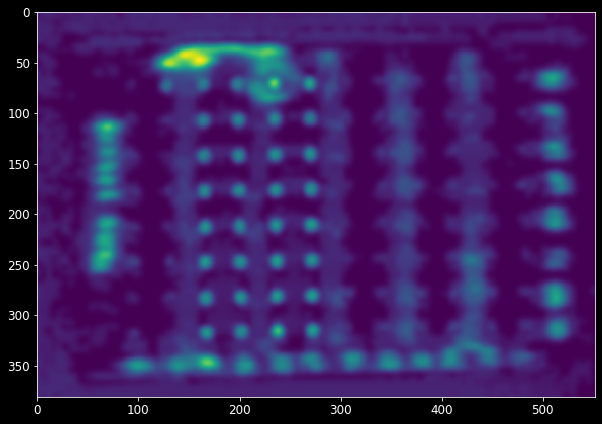

In [307]:
plt.figure(figsize=(10,10))
saturation = hsv_pic[:, :, 1].copy()
saturation = scipy.ndimage.filters.gaussian_filter(saturation, int(well_size / 3))
plt.imshow(saturation)

In [292]:
%%time
#plt.figure(figsize=(10,10))


#Use the saturation to maks wells with samples
saturation = hsv_pic[:, :, 1].copy()
saturation = scipy.ndimage.filters.gaussian_filter(saturation, int(well_size / 3))

sat_thresholds, sat_threshold_result = np.array([]), np.array([])
#sat_thresholds = []
#sat
for t in np.arange(0, 1, 0.01):
    mask_sat = saturation > t
    mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
    labels, nobjects = ndimage.label(mask_sat.astype(int))
    sat_thresholds = np.append(sat_thresholds, t)
    sat_threshold_result = np.append(sat_threshold_result, nobjects)

sat_result_mask = np.bitwise_and(sat_threshold_result > 0, sat_threshold_result <= plate_size)
mode = statistics.mode(sat_threshold_result[sat_result_mask])
sat_threshold = sat_thresholds[sat_threshold_result == mode][int(sat_thresholds[sat_threshold_result == mode].shape[0]/2)]

mask_sat = saturation > sat_threshold
mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
labels, nobjects = ndimage.label(mask_sat.astype(int))

#plt.imshow(mask_sat)

CPU times: user 3.59 s, sys: 0 ns, total: 3.59 s
Wall time: 3.59 s


In [316]:
%%time
#Use the saturation to maks wells with samples
saturation = hsv_pic[:, :, 1].copy()
saturation = scipy.ndimage.filters.gaussian_filter(saturation, int(well_size / 3))

# Iterate through thresholds to find wells with samples
sat_thresholds = []
sat_threshold_result = []
for t in np.arange(0.005, 1, 0.001):
    mask_sat = saturation > t
    mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
    labels, nobjects = ndimage.label(mask_sat.astype(int))
    sat_thresholds.append(t)
    sat_threshold_result.append(nobjects)
    if nobjects == 0:
        break
sat_thresholds = np.array(sat_thresholds)
sat_threshold_result = np.array(sat_threshold_result) 

# Find the threshold for the positive wells
sat_result_mask = np.bitwise_and(sat_threshold_result > 10, sat_threshold_result <= plate_size)
mode = stats.mode(sat_threshold_result[sat_result_mask])[0]
#try:
#    mode = statistics.mode(sat_threshold_result[sat_result_mask])
#except StatisticsError:
    
sat_threshold = sat_thresholds[sat_threshold_result == mode][int(sat_thresholds[sat_threshold_result == mode].shape[0]/2)]

# Make the final mask with the found threshold
mask_sat = saturation > sat_threshold
mask_sat = binary_dilation(mask_sat, iterations= int(well_size/5))
labels, nobjects = ndimage.label(mask_sat.astype(int))

CPU times: user 1.02 s, sys: 16 µs, total: 1.02 s
Wall time: 1.02 s


In [315]:
stats.mode(sat_threshold_result[sat_result_mask])[0]

array([52])

In [312]:
from scipy import stats

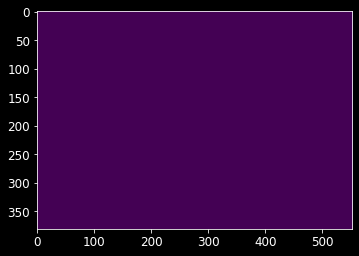

In [309]:
plt.imshow(mask_sat)

In [290]:
from collections import Counter

In [295]:
Counter(sat_threshold_result)

Counter({35: 5,
         45: 3,
         43: 3,
         47: 2,
         52: 6,
         55: 8,
         59: 12,
         57: 10,
         50: 4,
         53: 2,
         39: 3,
         32: 4,
         25: 4,
         24: 2,
         22: 2,
         23: 1,
         28: 2,
         27: 2,
         33: 2,
         29: 1,
         30: 2,
         36: 2,
         37: 2,
         38: 1,
         40: 2,
         46: 2,
         49: 5,
         51: 2,
         58: 8,
         60: 11,
         56: 7,
         54: 1,
         41: 1,
         34: 1,
         31: 1,
         21: 1,
         20: 2,
         19: 1,
         15: 1,
         14: 2,
         12: 1,
         10: 2,
         9: 4,
         8: 3,
         7: 5,
         6: 1,
         5: 3,
         4: 2,
         3: 5,
         2: 3,
         1: 13,
         0: 1})

In [43]:
import statistics

In [80]:
r  = np.array(result)
statistics.mode(r[r>0])
ts = np.array(ts)

result_mask = np.bitwise_and(r>0, r<=plate_size)
mode = statistics.mode(r[result_mask])
ts[r==mode][int(ts[r==mode].shape[0]/2)]

In [83]:
result_mask = np.bitwise_and(r>0, r<=plate_size)
mode = statistics.mode(r[result_mask])
ts[r==mode][int(ts[r==mode].shape[0]/2)]

In [87]:
ts[r==mode][int(ts[r==mode].shape[0]/2)]

0.1

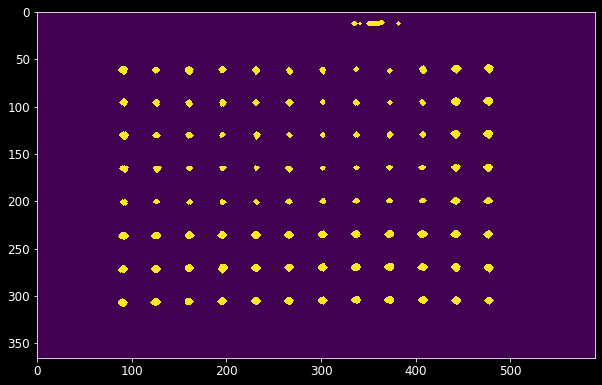

In [78]:
plt.figure(figsize=(10,10))

val = hsv_pic[:, :, 2].copy()
threshold_v= 0.461
mask_val = val>threshold_v
mask_val = binary_dilation(mask_val, iterations=2)

plt.imshow(mask_val)

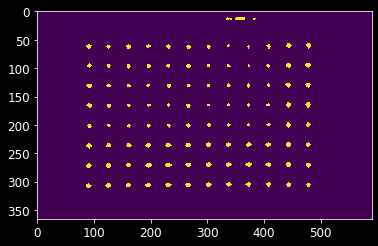

In [79]:
plt.imshow(mask_val)